In [218]:
using Eirene
using MAT
import Pkg
#Pkg.add("PyPlot")
Pkg.add("ORCA")
#using PyPlot
using LinearAlgebra
using Statistics
using Printf
using WebIO
WebIO.install_jupyter_nbextension()
using Plotly
using ORCA

Pkg.add("Distributions")
using Distributions

using Random

## WSBM Generator

### SBM version

In [89]:
function generate_clusters(n=100,pi_vector=[0.3,0.4,0.3])
    clusters_splits=round.(Int,cumsum(n*pi_vector))
    k = size(pi_vector)[1]
    c = zeros(Int8,n) 
    for k_ind in collect(0:k-2)
        c[clusters_splits[k_ind+1]:clusters_splits[k_ind+2]].=k_ind+1
    end
    return c
end

generate_clusters (generic function with 3 methods)

In [128]:
function generate_sbm_adj(n,pi_vector,theta_in,theta_out)
    c=generate_clusters(n,pi_vector)
    Adj=zeros(Int8,n,n)
    for i in collect(1:n-1)
        for j in collect(i+1:n)
            if c[i]==c[j]
                Adj[i,j]=round.(Int,rand((0:100))<100*theta_in)
                Adj[j,i]=Adj[i,j]
                else
                Adj[i,j]=round.(Int,rand((0:100))<100*theta_out)
                Adj[j,i]=Adj[i,j]
            end
        end
    end
    return Adj
end

generate_sbm_adj (generic function with 1 method)

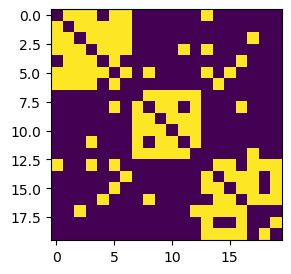

PyObject <matplotlib.image.AxesImage object at 0x000000003F141FC8>

In [133]:
Adj = generate_sbm_adj(20,[0.4,0.3, 0.3],0.9,0.1)
plt.figure(figsize=(3,3))
imshow(Adj)

### Weighted Version

Я чуть изменила функцию, добавила в конец два опциональных параметра: номер усиливаемого блока и параметр усиления - это для моделей с выделенной группой нодов. 

In [283]:
function generate_wsbm_adj(n,pi_vector,theta_in,theta_out,n_block=nothing,enh_param=nothing)
     c=generate_clusters(n,pi_vector)
     Adj=zeros(Float64,n,n)
     for i in collect(1:n-1)
        for j in collect(i+1:n)
            if c[i]==c[j]
                if n_block==nothing
                    Adj[i,j]=rand(LogitNormal(rand(Normal(theta_in),1)[1]))
                    Adj[j,i]=Adj[i,j]
                else
                    if c[i]==n_block-1
                        Adj[i,j]=rand(LogitNormal(rand(Normal(theta_in),1)[1]))*enh_param
                        Adj[j,i]=Adj[i,j]
                    else
                        Adj[i,j]=rand(LogitNormal(rand(Normal(theta_in),1)[1]))
                        Adj[j,i]=Adj[i,j]
                    end
                end
            else
                 Adj[i,j]=rand(LogitNormal(rand(Normal(theta_out),1)[1]))
                 Adj[j,i]=Adj[i,j]
            end
        end
    end
    Adj[diagind(Adj)].= 1
    return Adj
end
                    

generate_wsbm_adj (generic function with 3 methods)

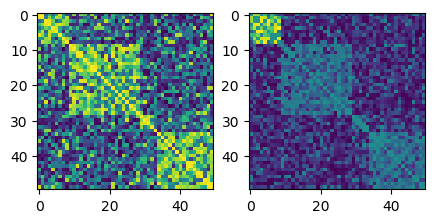

PyObject <matplotlib.image.AxesImage object at 0x0000000053FDED88>

In [284]:
wAdj = generate_wsbm_adj(50,[0.2,0.4,0.1,0.3],1,-1)
wAdj_enh = generate_wsbm_adj(50,[0.2,0.4,0.1,0.3],1,-1,1,2)
plt.figure(figsize=(5,5))
subplot(121); imshow(wAdj)
subplot(122); imshow(wAdj_enh)

In [224]:
function random_permute(matrix)
    n=size(matrix)[1]
    order=randperm(n)
    permuted=zeros(Float64,n,n)
    for i in collect(1:n-1)
            for j in collect(i+1:n)
                permuted[i,j]=matrix[order[i],order[j]]
                permuted[j,i]=matrix[order[j],order[i]]
            end
        end
    return order, permuted
end             

random_permute (generic function with 1 method)

In [230]:
function inverse_permute(order,permuted)
    n=size(permuted)[1]
    new_order=sortperm(order)
    inverse=zeros(Float64,n,n)
    for i in collect(1:n-1)
        for j in collect(i+1:n)
            inverse[i,j] = permuted[new_order[i],new_order[j]]
            inverse[j,i] = permuted[new_order[j],new_order[i]]
        end
    end
    return inverse
end         

inverse_permute (generic function with 1 method)

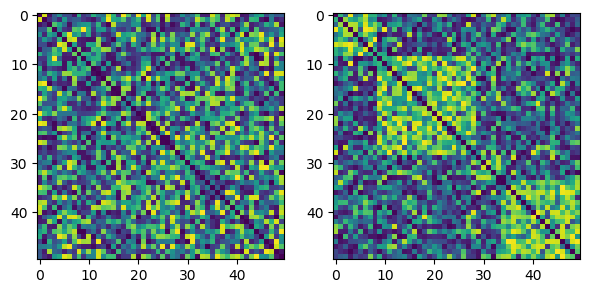

PyObject <matplotlib.image.AxesImage object at 0x000000004D3CDC08>

In [234]:
plt.figure(figsize = (7,7))
wAdj = generate_wsbm_adj(50,[0.2,0.4,0.1,0.3],1,-1)
order,permuted =random_permute(wAdj)
subplot(121); imshow(permuted)
subplot(122); imshow(inverse_permute(order, permuted))

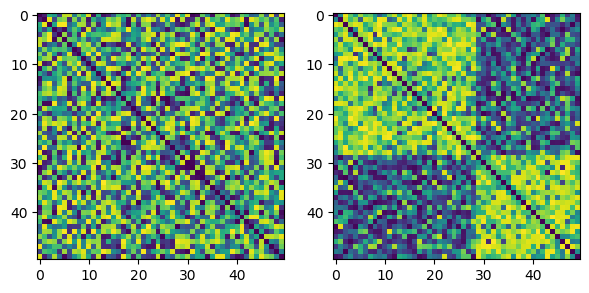

PyObject <matplotlib.image.AxesImage object at 0x00000000540720C8>

In [285]:
plt.figure(figsize = (7,7))
number_of_nodes=50
pi_vector=[0.6,0.4]
theta_in=1.5
theta_out=-1
wAdj = generate_wsbm_adj(number_of_nodes,pi_vector,theta_in,theta_out)
order,permuted =random_permute(wAdj)
subplot(121); imshow(permuted)
subplot(122); imshow(inverse_permute(order, permuted))

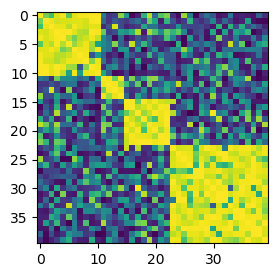

Dict{String,Any} with 12 entries:
  "symmat"   => [712 21 … 488 317; 21 712 … 582 471; … ; 488 582 … 712 0; 317 4…
  "maxnz"    => [0, 529, 5463, 41865, 0]
  "firstv"   => Array{Int64,1}[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  32, 33, 34, 3…
  "cyclerep" => Array{Array{Int64,1},1}[[], [[1, 5], [4, 3], [11, 27], [1, 35],…
  "phi"      => Array{Int64,1}[[], [4, 77, 343, 169, 193, 127, 126, 563, 689, 2…
  "plo"      => Array{Int64,1}[[], [5, 3, 27, 35, 26, 25, 24, 21, 36, 30  …  16…
  "ocg2rad"  => [0.91937, 0.919264, 0.918166, 0.917692, 0.917371, 0.916931, 0.9…
  "farfaces" => Array{Int64,1}[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  31, 32, 33, 3…
  "nvl2ovl"  => [15, 14, 17, 11, 8, 12, 19, 13, 16, 5  …  35, 4, 34, 31, 36, 32…
  "input"    => Dict{String,Any}("genera"=>[0.0 0.740882 … 0.42522 0.269628; 0.…
  "tid"      => Array{Int64,1}[[], [5, 3, 27, 35, 26, 25, 24, 21, 36, 30  …  14…
  "grain"    => Array{Int64,1}[[712, 712, 712, 712, 712, 712, 712, 712, 712, 71…

In [300]:
number_of_nodes=40
pi_vector=[0.3,0.1,0.2,0.4]
theta_in=3
theta_out=-1 
wAdj=generate_wsbm_adj(number_of_nodes,pi_vector,theta_in,theta_out)
plt.figure(figsize=(3,3))
imshow(wAdj)
wAdj_name=string(number_of_nodes,"_nodes_",size(pi_vector)[1],"_blocks")
wAdj_distance=get_distance(wAdj)
C=TDA(wAdj_distance,wAdj_name)

In [301]:
plotbarcode_pjs(C,dim=1)

data: [
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields line, mode, showlegend, type, x, and y",
  "scatter with fields l

In [302]:
plotbetticurve_pjs(C,dim=1)

data: [
  "scatter with fields line, mode, type, x, and y"
]

layout: "layout with fields height, hovermode, margin, scene, showlegend, and width"

In [293]:
function get_distance(matrix, pos = true)
    if !pos
        matrix = matrix.*-1
    end
    matrix[findall(matrix.< 0)].=0;
    #distC=((matrix./10).+2).^(-1)
    distC = ((matrix.-1).*(-1)).^0.5;
    distC[diagind(distC)].= 0; 
    return distC
end

get_distance (generic function with 2 methods)

In [6]:
function TDA(matrix,matrix_name)
    dist_mat=get_distance(matrix)
    C=eirene(dist_mat,maxdim=2)
    #filename=string(cur_dir,"TDA_Results/",matrix_name,"_cycle_reps.txt")
    #write_barcode_to_file(C,filename)
    return C
end
    

TDA (generic function with 1 method)

In [7]:
function print_all_reprs(C, dim)
    b=barcode(C,dim=dim)
    num=size(b)[1]
    intervals=[string("Dimension: ",dim,"\n")]
    println("Printing",intervals[1])
    for j in collect(1:size(b)[1])
        ints=@sprintf "[%.3f, %.3f): " b[j,1] b[j,2]
        repr=classrep(C, class=j, dim=dim)
        simplList=[]
        for i in collect(1:size(repr)[2])
            push!(simplList,"["*join(string.(repr[:,i]),",")*"]")
        end
        push!(intervals, string(ints, join(simplList,"+")))
    end
    return sort(intervals)
end

print_all_reprs (generic function with 1 method)

In [8]:
function write_barcode_to_file(C, filename; maxdim = 2)

    open(filename,"w") do f
        
        for dim in collect(0:maxdim)
        
            b = barcode(C, dim = dim)
            num = size(b)[1]
        
            write(f,string("Dimension: ", dim,"\n"))
            #println(string("Dimension: ", dim,"\n"))
                  
            
            for j in collect(1:num)
    
                ints = @sprintf "[%.3f, %.3f): " b[j,1] b[j,2]
                repr = classrep(C, class = j, dim = dim)
                part1 = @sprintf "[%.3f, %.3f): " b[j,1] b[j,2]
            
                simplList = []
                for i in collect(1:size(repr)[2]) 
                    push!(simplList,"["*join(string.(repr[:,i]),",")*"]")
                end 
            
                part2 = string(part1, join(simplList,"+"),"\n")
                write(f,part2)
            end
        end
        
    end
end

write_barcode_to_file (generic function with 1 method)

In [15]:
for i in collect(1:size(groups_of_models)[1])
    C=TDA(groups_of_models[i],groups_of_variable_names[i])
    #for dim in collect(0:2)
    #plotbarcode_pjs(C,dim=1)
    #savefig(string(cur_dir,"TDA_Results_Images/barcode_",groups_of_variable_names[i],"_dim",1,".png"))
    #plotbetticurve_pjs(C,dim=1)
    #savefig(string(cur_dir,"TDA_Results_Images/betti_curve_",groups_of_variable_names[i],"_dim",1,".png"))
    end
end

UndefVarError: UndefVarError: savefig not defined

Старые функции для доступа к данным

In [2]:
function get_access_to_data(cur_dir, distr_name,n_blocks, n_nodes)
    folder_path=string(cur_dir,distr_name,"_Distr/")
    substr=string(distr_name,"_",n_blocks,"b_",n_nodes,"n_")
    file_path=""
    file_path_enh=""
    for i in collect(1:size(readdir(folder_path))[1])
        if occursin(substr,readdir(folder_path)[i])==true
            if occursin("enh",readdir(folder_path)[i])==false
                file_path=string(folder_path,readdir(folder_path)[i])
            else 
                file_path_enh=string(folder_path,readdir(folder_path)[i])
        end
        end
    end
    model_matrix=matread(file_path)["standard_model"]
    model_matrix_enh=matread(file_path_enh)["node_enhanced_model"]
    return model_matrix, model_matrix_enh
    end

get_access_to_data (generic function with 1 method)

In [3]:
function grouping_models(cur_dir,params_list,distr_name)
    list_of_models=[]
    list_of_models_names=[]
    for i in collect(1:size(params_list)[1])
        append!(list_of_models,get_access_to_data(cur_dir,distr_name,params_list[i][1],params_list[i][2]))
        push!(list_of_models_names, string(distr_name[1],"_",params_list[i][1],"b_",params_list[i][2],"n"))
        push!(list_of_models_names, string(distr_name[1],"_",params_list[i][1],"b_",params_list[i][2],"n_enh"))
        end
    return list_of_models,list_of_models_names
end

grouping_models (generic function with 1 method)

In [4]:
cur_dir="C:/Users/806618/TDA_model_data/";
distr_names=["Normal","Poisson","Exponential"]
params_list=[(3,5),(3,7),(4,5),(5,7),(6,5)]

groups_of_models=[]
groups_of_variable_names=[]
for distr in distr_names
    append!(groups_of_models,grouping_models(cur_dir,params_list,distr)[1])
    append!(groups_of_variable_names,grouping_models(cur_dir,params_list,distr)[2])
end